## Simulation with using influx or loss

## 2500m inclined well

In [24]:
import openlab
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import time
import random
import pprint as pr
from IPython.display import clear_output
import datetime
import os
import subprocess
import seaborn as sns

In [2]:
# Warnings are provided to warn the developer of situations that aren’t necessarily exceptions. 
#Usually, a warning occurs when there is some obsolete of certain programming elements.
#Python program terminates immediately if an error occurs. Conversely, a warning is not critical.

import warnings
warnings.filterwarnings('ignore')

### Logging in and creating session

In [3]:
username="hh.kjolle@stud.uis.no"
apikey="8D44DA8C3A7BDC651D325F0476A2AB776938FE99D57050559EF951D33ABCCFAB"
licenseguid="c3a0315b-813c-4e0b-8ec9-e14436a1783d"

In [4]:
session = openlab.http_client(username=username, apikey=apikey,licenseguid=licenseguid) #this intializes an http client that can be used for an entire openlab session

12:58:24 [INFO] Initializing Openlab http client
12:58:24 [INFO] Creating token
12:58:24 [INFO] Saving token
12:58:24 [INFO] Login Succesfull


### Simulation information

In [5]:
# each simulation lasts 2 minutes, and there are to be 98 simulations with varying setpoints.
single_simulation_lenght = 10 #min
total_simulation_length = 30/60 #hrs

step_per_sim = single_simulation_lenght*60
nr_sim = int(total_simulation_length*60/single_simulation_lenght)
total_steps = nr_sim*step_per_sim

print(f"There will be {nr_sim} simulations, lasting for {single_simulation_lenght} minutes, equalling to {total_steps} timeSteps.")

There will be 3 simulations, lasting for 10 minutes, equalling to 1800 timeSteps.


### Manual Loss Model

In [6]:
sim_name = "loss"
config_name = "test1"
initial_bit_depth = 2500
influx_mode = openlab.default_manual_loss

#### Starting simulation of manual loss model

In [7]:
manual_influx_loss_mass_rate = random.randint(-19999, 0) / 60 # Max = -19999 kg/min
manual_influx_loss_total_mass = random.randint(0, 20000) # Max = 20000 kg
    
sim = session.create_simulation(
    config_name, 
    sim_name, 
    initial_bit_depth, 
    influx_mode=influx_mode,
    ComplexReservoirKickOffTime=300,
    Id="ManualLoss",
    ManualInfluxLossMD=2505,
    ManualInfluxLossMassRate= manual_influx_loss_mass_rate, 
    ManualInfluxLossTotalMass=manual_influx_loss_total_mass, 
    ManualReservoirMode=True,
    UseReservoirModel=True
)

12:58:25 [INFO] User limits: {'ActiveSimulationCount': 3, 'MaxConcurrentSimulations': 5, 'MaxSimulationCount': 0, 'MaxStepCount': 180000, 'MaxStoredSimulations': 10, 'MaxTimeStep': 18000, 'TotalSimulationCount': 415, 'UsedCapacityPercent': 4, 'UsedStepCount': 7927}
12:58:25 [INFO] ManualLoss selected
12:58:40 [INFO] Simulation Initialized


In [8]:
#sim2.setpoints.SurfaceRPM = 140/60 #rpm to rotation per second
#sim2.setpoints.TopOfStringVelocity = 0.656 #m/s
#sim2.setpoints.DesiredWOB = 10 * 1000 # 5 metric tons converted to SI unit of kg
#sim2.setpoints.FlowRateIn = 2500/60000 #converting l/min to m^3/s

### Unit Converter

In [9]:
FLOW_UNIT_CONV_FACTOR= 1.66666667 * 0.00001#float("10e-5") # l/min --> m^3/s
PRESSURE_CONV_FACTOR= 100000.0 # float("10e5") # bar-->pascal
WEIGHT_CONV_FACTOR = 0.001 # float ("10e3") # kg to tons

In [10]:
# variable setpoints
# random lists
SurfaceRPM = [random.randint(0, 220) for _ in range(nr_sim)]
SurfaceRPM = [rpm/60 for rpm in SurfaceRPM]

DesiredWOB = [random.randint(0, 40) for _ in range(nr_sim)]
DesiredWOB = [wob*1000 for wob in DesiredWOB]

FlowRateIn = [random.randint(0, 3000) for _ in range(nr_sim)]
FlowRateIn = [flow_rate/60000 for flow_rate in FlowRateIn]

### Results which are relevant

In [11]:
# dataframe and tags stuff
tags = ['SPP', 'DownholeECD', 'FlowRateOut', 'HookLoad', 'SurfaceTorque', 'BitDepth', 'TD', 'ChokeOpening', 'DownholePressure', 'ChokePressure', 'FluidTemperatureOut', 'WOB', 'InstantaneousROP', 'FlowRateIn', 'TopOfStringVelocity', 'SurfaceRPM', 'DrillstringTemperature', 'TotalInfluxMass', 'CalculatedPressureBottomHole', 'CuttingsMassFractionTransient', 'FluidTemperatureIn', 'AnnulusECD', 'AnnulusTemperature', 'DrillstringTension', 'AnnulusFluidVelocity', 'DrillstringFluidVelocity', 'CuttingsBedHeight', 'AnnulusDensity', 'DrillstringTorque', 'TotalMudLossMass', 'TopOfStringPosition', 'ActivePitVolume', 'ActivePitDensity', 'ActivePitTemperature', 'MainPitVolume', 'MainPitDensity', 'MainPitTemperature', 'ReservePitVolume', 'ReservePitDensity', 'ReservePitTemperature']
ID = ["sim_ID", "timeStep"]
columns = tags + ID


df = pd.DataFrame(columns=columns)

### Running through the simulations

In [12]:
startTime = 1
endTime = single_simulation_lenght*60

timeStep = 1
current_simulation = 0

sim.stop()

while current_simulation < nr_sim:
    
    print(f"Simulation {current_simulation + 1}/{nr_sim}")
    
    sim_ID = current_simulation
    
    manual_influx_loss_mass_rate = random.randint(-19999, 0) / 60 # Max = -19999 kg/min
    manual_influx_loss_total_mass = random.randint(0, 20000) # Max = 20000 kg
    
    sim = session.create_simulation(
        config_name, 
        sim_name, 
        initial_bit_depth, 
        influx_mode=influx_mode,
        ComplexReservoirKickOffTime=300,
        Id="ManualLoss",
        ManualInfluxLossMD=2505,
        ManualInfluxLossMassRate= manual_influx_loss_mass_rate, 
        ManualInfluxLossTotalMass=manual_influx_loss_total_mass, 
        ManualReservoirMode=True,
        UseReservoirModel=True
    )
    
    sim.setpoints.SurfaceRPM = SurfaceRPM[0+current_simulation]
    sim.setpoints.DesiredWOB = DesiredWOB[0+current_simulation]
    sim.setpoints.FlowRateIn = FlowRateIn[0+current_simulation]
    sim.setpoints.TopOfStringVelocity = 0.02 #m/s
    sim.setpoints.DesiredROP = 0.02
    values = {}
    while timeStep <= endTime:

        sim.step(timeStep) # stepping openlab
        sim.get_results(timeStep, tags) # fetching results

        for feature in tags:
            # Skip "Connection" feature
            if feature == "Connection":
                continue
            # Create the variable name for the current feature
            var_name = f"{feature}"
            # Extract the value of the feature at this time step
            value_dict = eval(f"sim.results.{var_name}")
            value = list(value_dict.values())[-1]  # Extract the value as a number
            # Add the value to the dictionary
            values[feature] = value

        # Update other variables based on the current time step and simulation ID, and add them to the dictionary
        values['timeStep'] = timeStep
        values['sim_ID'] = sim_ID

        # Append the dictionary to the dataframe
        df = df.append(values, ignore_index=True)
        print(df.tail(1))
        clear_output(wait=True)
        
        # Increment the time step
        timeStep += 1

    # Print the entire dataframe after the inner while loop has completed
    print(df)
    
    sim.stop()
    timeStep = 1
    current_simulation += 1

print("All simulations completed.")

13:05:57 [INFO] Ending simulation 25828acd-d14f-4551-9816-783b43ec06b2
13:05:57 [INFO] 25828acd-d14f-4551-9816-783b43ec06b2 was completed


               SPP  DownholeECD   FlowRateOut       HookLoad  SurfaceTorque  \
0     2.187453e+05  1652.007544 -1.736208e-07  116223.128935     392.142704   
1     1.439073e+06  1652.007939 -2.345494e-07  115988.210113     530.641739   
2     1.975128e+06  1652.083676  3.157034e-05  115884.282792     668.694736   
3     2.647781e+06  1652.206896  6.747568e-05  115751.732274     806.348795   
4     3.400404e+06  1652.389424  9.165266e-05  115602.947407     943.643155   
...            ...          ...           ...            ...            ...   
1795  1.045676e+07  1725.532001  2.699126e-02   91468.582137    6812.099848   
1796  1.045710e+07  1725.556213  2.699185e-02   91468.314792    6811.959024   
1797  1.045749e+07  1725.583160  2.699245e-02   91468.032045    6811.990664   
1798  1.045784e+07  1725.543629  2.699302e-02   91467.716077    6812.041118   
1799  1.045814e+07  1725.551366  2.699379e-02   91467.343710    6811.899847   

         BitDepth           TD  ChokeOpening  Downh

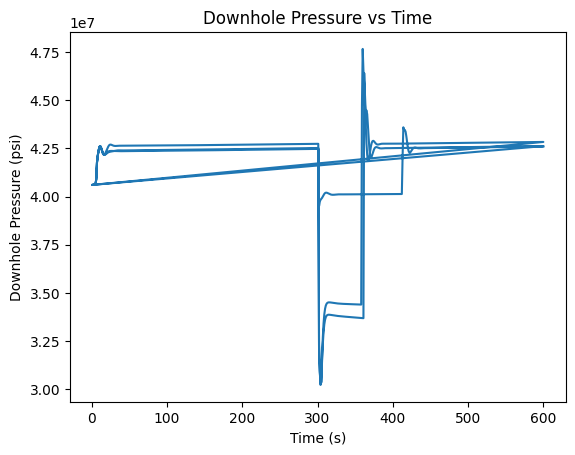

In [13]:
# Extract the downhole pressure and timeStep from the df DataFrame
downhole_pressure = df['DownholePressure']
time_step = df['timeStep']

# Create a line plot
plt.plot(time_step, downhole_pressure)

# Add labels and title
plt.xlabel('Time (s)')
plt.ylabel('Downhole Pressure (psi)')
plt.title('Downhole Pressure vs Time')

# Show the plot
plt.show()


In [18]:
# Save the results to a CSV file with a simulation identifier and current date and time
simulation_id = "loss"
current_time = datetime.datetime.now().strftime("%Y-%m-%d %H-%M")
file_name = f"results_{simulation_id}_{current_time}.csv"
df.to_csv(file_name, index=False)

In [19]:
# specify the simulation identifier used to save the file
simulation_id = "loss"

# construct the file name of the CSV file to read
current_time = datetime.datetime.now().strftime("%Y-%m-%d %H-%M")
file_name = f"results_{simulation_id}_{current_time}.csv"

# read the CSV file into a pandas DataFrame
df = pd.read_csv(file_name)

# open the CSV file using the default program associated with CSV files
if os.name == 'nt':  # for Windows
    os.startfile(file_name)
else:  # for Mac and Linux
    subprocess.call(('open', file_name))


In [20]:
file_name

'results_loss_2023-03-15 13-30.csv'

In [21]:
df_loss = df
%store df_loss

Stored 'df_loss' (DataFrame)
